#### Step 1: Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
from pandarallel import pandarallel
import matplotlib.pyplot as plt
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### Step 2: Load and Preprocess Data

In [2]:
# Load the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Drop rows with missing values (if any)
df.dropna(inplace=True)

In [12]:
print(df.head())

                                             trip_id  \
0  0012cf835ee80e59fefbe618282b2edc082940ddba6a46...   
1  0016d7b5510107039e65db431a77047ccd381c975ac910...   
2  00173c2c51ac526bcabae2e29f42cfbdcd5f4868f4bb0a...   
3  001f4a8d66681721bead8b8d279e99020314facd7d79de...   
4  002c53591ec14d4303a02f331e9422ae2c26090f1f0146...   

                                            time_gap      dist  \
0  [0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0...  8.411882   
1  [0.0, 5.0, 10.0, 242.0, 282.0, 292.0, 292.0, 2...  0.823876   
2  [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...  7.929678   
3  [0.0, 5.0, 25.0, 35.0, 45.0, 55.0, 75.0, 85.0,...  6.138370   
4  [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...  7.065255   

                                                lats  \
0  [31.955, 31.955, 31.955, 31.955, 31.955, 31.95...   
1  [31.949, 31.949, 31.949, 31.949, 31.949, 31.94...   
2  [31.955, 31.955, 31.955, 31.955, 31.955, 31.95...   
3  [32.003, 32.003, 32.003, 32.003, 32.003

#### Step 3: Prepare Features and Target

In [3]:
# Feature extraction functions
def extract_features(row):
    features = {}
    features['mean_time_gap'] = np.mean(row['time_gap'])
    features['std_time_gap'] = np.std(row['time_gap'])
    features['min_time_gap'] = np.min(row['time_gap'])
    features['max_time_gap'] = np.max(row['time_gap'])
    
    features['mean_lat'] = np.mean(row['lats'])
    features['std_lat'] = np.std(row['lats'])
    features['min_lat'] = np.min(row['lats'])
    features['max_lat'] = np.max(row['lats'])
    
    features['mean_lng'] = np.mean(row['lngs'])
    features['std_lng'] = np.std(row['lngs'])
    features['min_lng'] = np.min(row['lngs'])
    features['max_lng'] = np.max(row['lngs'])
    
    features['mean_dist_gap'] = np.mean(row['dist_gap'])
    features['std_dist_gap'] = np.std(row['dist_gap'])
    features['min_dist_gap'] = np.min(row['dist_gap'])
    features['max_dist_gap'] = np.max(row['dist_gap'])
    
    return pd.Series(features)

#### Step 4: Split the Data

In [13]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Apply feature extraction to each subset
train_features = X_train.apply(extract_features, axis=1)
test_features = X_test.apply(extract_features, axis=1)

# Combine features with other relevant columns
X_train = pd.concat([train_features, X_train[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)
X_test = pd.concat([test_features, X_test[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)

# Convert non-numeric columns to numeric or drop them
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

#### Step 5: Hyperparameter Tuning and Model Training

##### Parameter Grid Search

In [14]:
# param_grid = {
#     'n_estimators': list(range(1, 202, 50)),
#     'max_depth': list(range(1, 8)),
#     'min_samples_leaf': list(range(1, 10)),
#     'max_leaf_nodes': [None] + list(range(10, 20, 2)),
#     'random_state': [42],
#     'criterion': ['squared_error', 'absolute_error']
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring='neg_root_mean_squared_error')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# model = RandomForestRegressor(**best_params)
# model.fit(X_train, y_train)

##### Narrow down the parameter grid search

##### Only one parameter

In [15]:
# Recommended initial hyperparameter values
n_estimators = 100
max_depth = None  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_leaf = 1  # The minimum number of samples required to be at a leaf node
max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
criterion = 'squared_error'  # Default criterion for regression tasks

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    random_state=random_state,
    criterion=criterion
)

model.fit(X_train.drop(columns=['trip_time']), y_train)

# Evaluate the model
y_pred = model.predict(X_test.drop(columns=['trip_time']))
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 4.267577732134756


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



#### Step 6: Evaluate the Model with Learning Curves

In [16]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.show()

#### Step 7: Make Predictions and Calculate Errors

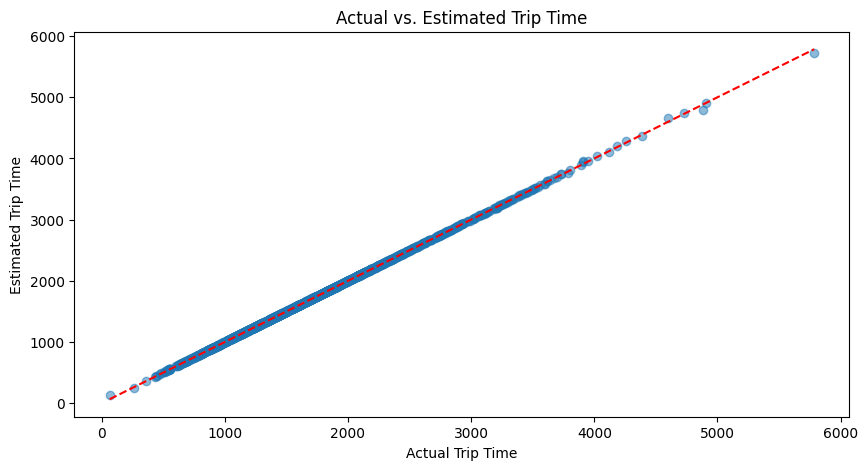

Mean Absolute Error (MAE): 0.8883364602876745
R^2 Score: 0.9999617087281472


In [17]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time')
    plt.show()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
get_metrics(plot_df)